# SQL Database agent

In this cookbook, we will walk through how to build an agent that can answer questions about a SQL database. 

We'll also show how to evaluate it in 3 different ways. See our conceptual guide and agent tutorial for added context:
  
* [Conceptual guide for evaluations](https://docs.smith.langchain.com/concepts/evaluation)
* [Guide for agent evaluations](https://docs.smith.langchain.com/tutorials/Developers/agents)

## Set up environment

We'll set up our environment variables for OpenAI, and optionally, to enable tracing with [LangSmith](https://smith.langchain.com).

In [ ]:
# !pip install --upgrade --quiet langchain langsmith langchain-community langchain-experimental langgraph

In [ ]:
import json
import os
import sqlite3
import uuid
from ast import literal_eval
from pprint import pprint

import pandas as pd
import requests
from arize_otel import Endpoints, register_otel
from dotenv import load_dotenv
from langchain.agents import tool
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.prebuilt.tool_node import ToolNode
from openinference.instrumentation.langchain import LangChainInstrumentor
from tqdm import tqdm

from phoenix.evals import (
    SQL_GEN_EVAL_PROMPT_TEMPLATE,
    SQL_GEN_EVAL_PROMPT_RAILS_MAP,
    llm_classify,
    OpenAIModel,
)

from getpass import getpass
import numpy as np

In [ ]:
load_dotenv()

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Configure the database

We will be creating a SQLite database for this tutorial. SQLite is a lightweight database that is easy to set up and use. We will be loading the `chinook` database, which is a sample database that represents a digital media store.
Find more information about the database [here](https://www.sqlitetutorial.net/sqlite-sample-database/).

For convenience, we have hosted the database (`Chinook.db`) on a public GCS bucket.

In [ ]:
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

We will use a handy SQL database wrapper available in the `langchain_community` package to interact with the database. The wrapper provides a simple interface to execute SQL queries and fetch results. We will also use the `langchain_openai` package to interact with the OpenAI API for language models later in the tutorial.

In [ ]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

In [ ]:
db.run("SELECT * FROM Artist where name = 'Led Zeppelin';")

## SQL Agent

We'll use a [LangGraph agent](https://www.langchain.com/agents) with access to a set of tools for working with SQL:

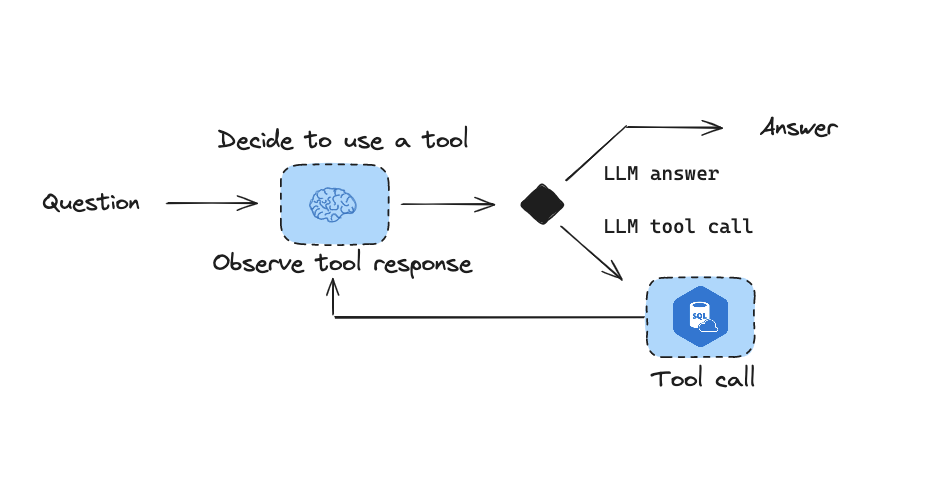

### LLM

In [ ]:
### gpt4o
llm = ChatOpenAI(model="gpt-4o", temperature=0)
experiment_prefix = "sql-agent-gpt4o"
metadata = "Chinook, gpt-4o base-case-agent"

### Tools
 
We'll use [SQL toolkit](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents) as well as some custom tools to check the query before executing it and check the query result from the database to confirm it is not empty or irrelevant to the question.

In [ ]:
# SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Query checking
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("user", "{query}")]
)
query_check = query_check_prompt | llm


@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content


# Query result checking
query_result_check_system = """You are grading the result of a SQL query from a DB. 
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""
query_result_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_result_check_system), ("user", "{query_result}")]
)
query_result_check = query_result_check_prompt | llm


@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant.
    """
    return query_result_check.invoke({"query_result": query_result}).content


tools.append(check_query_tool)
tools.append(check_result)

### State

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### SQL Assistant

Here, we lay out the instructions of our agent, building on this [prompt](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents).

In [ ]:
# Assistant
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Append to state
            state = {**state}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [
                    ("user", "Respond with a real output.")
                ]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Assistant runnable
query_gen_system = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it. 
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, use check_result tool to check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
assistant_runnable = query_gen_prompt | llm.bind_tools(tools)

### Graph Utilities

We will define a few utility functions to help us with the agent implementation. Specifically, we will wrap a ToolNode with a fallback to handle errors and surface them to the agent.

In [ ]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

### Graph

We will then define the workflow for the agent.

In [ ]:
# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")

### Auto-Instrument Agent

In [ ]:
ARIZE_SPACE_KEY = os.getenv("ARIZE_SPACE_KEY")  # in app space settings page
ARIZE_API_KEY = os.getenv("ARIZE_API_KEY")  # in app space settings page
MODEL_NAME = "arize_langgraph_video_20241003"

In [ ]:
register_otel(
    endpoints=Endpoints.ARIZE,
    space_key=ARIZE_SPACE_KEY,  # in app space settings page
    api_key=ARIZE_API_KEY,  # in app space settings page
    model_id=MODEL_NAME,  # name this to whatever you would like
    model_version="1",
)

LangChainInstrumentor().instrument()

### Invoke Agent

In [ ]:
sqlite3_conn = sqlite3.connect("Chinook.db", check_same_thread=False)
sqlite3_memory_checkpoint = SqliteSaver(sqlite3_conn)

graph = builder.compile(checkpointer=sqlite3_memory_checkpoint)

In [ ]:
questions = [
    "Which country's customers spent the most? And how much did they spend?",
    "How many albums does the artist Led Zeppelin have?",
    "What was the most purchased track of 2017?",
    "Which sales agent made the most in sales in 2009?",
]

In [ ]:
for question in tqdm(questions):
    _printed = set()
    thread_id = str(uuid.uuid4())

    config = {
        "configurable": {
            # Checkpoints are accessed by thread_id
            "thread_id": thread_id,
        }
    }

    msg = {"messages": ("user", question)}

    messages = graph.invoke(msg, config)

## Export Data, and Run Evals

In [ ]:
ARIZE_API_KEY = ""

import os

os.environ["ARIZE_API_KEY"] = ARIZE_API_KEY

from datetime import datetime

from arize.exporter import ArizeExportClient
from arize.utils.types import Environments

client = ArizeExportClient()

print("#### Exporting your primary dataset into a dataframe.")

trace_df = client.export_model_to_df(
    space_id=os.getenv("ARIZE_SPACE_ID"),
    model_id=MODEL_NAME,
    environment=Environments.TRACING,
    start_time=datetime.fromisoformat("2024-10-01T06:00:00.000+00:00"),
    end_time=datetime.fromisoformat("2024-10-04T05:59:59.999+00:00"),
    where="name = 'LangGraph'",
)

In [ ]:
subset_df = trace_df[
    [
        "context.span_id",
        "attributes.input.value",
        "attributes.output.value",
        "attributes.metadata",
    ]
][trace_df["attributes.metadata"].notna()].reset_index(drop=True)

In [ ]:
def format_input(text):
    return literal_eval(text)["messages"][1]

In [ ]:
subset_df["question"] = subset_df["attributes.input.value"].apply(format_input)

In [ ]:
def format_sql_query(text):
    temp_query = (
        literal_eval(text)["messages"][-3]
        .split("{'arguments': '")[1]
        .split(";")[0]
    )

    return temp_query.split("query")[1].split(":")[1].strip()

In [ ]:
subset_df["query_gen"] = subset_df["attributes.output.value"].apply(
    format_sql_query
)

In [ ]:
def format_output(text):
    return (
        literal_eval(text)["messages"][-1]
        .split("additional_kwargs")[0]
        .split("content=")[-1]
    )

In [ ]:
subset_df["response"] = subset_df["attributes.output.value"].apply(
    format_output
)

### Eval - SQL Generation

In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
rails = list(SQL_GEN_EVAL_PROMPT_RAILS_MAP.values())

model = OpenAIModel(
    model="gpt-4o",
    temperature=0.0,
)


relevance_classifications = llm_classify(
    dataframe=subset_df,
    template=SQL_GEN_EVAL_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
)

In [ ]:
relevance_classifications = relevance_classifications[["label", "explanation"]]

In [ ]:
relevance_classifications = relevance_classifications.rename(
    columns={
        "label": "eval.SQL Generation.label",
        "explanation": "eval.SQL Generation.explanation",
    }
)

In [ ]:
relevance_classifications["eval.SQL Generation.score"] = np.where(
    relevance_classifications["eval.SQL Generation.label"] == "correct", 1, 0
)

In [ ]:
subset_df["correct_answer"] = pd.Series(
    [
        "The country whose customers spent the most is the USA, with a total expenditure of $523.06",
        "Led Zeppelin has 14 albums",
        "The most purchased track of 2017 was Hot Girl.",
        "Steve Johnson made the most sales in 2009",
    ]
)

In [ ]:
subset_df["ai_generated_answer"] = subset_df["response"].copy()

In [ ]:
from phoenix.evals import (
    HUMAN_VS_AI_PROMPT_RAILS_MAP,
    HUMAN_VS_AI_PROMPT_TEMPLATE,
)

# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(HUMAN_VS_AI_PROMPT_RAILS_MAP.values())
ai_human_classifications = llm_classify(
    dataframe=subset_df,
    template=HUMAN_VS_AI_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    verbose=False,
    provide_explanation=True,
)

In [ ]:
ai_human_classifications = ai_human_classifications[["label", "explanation"]]

In [ ]:
ai_human_classifications = ai_human_classifications.rename(
    columns={
        "label": "eval.AI Groundtruth.label",
        "explanation": "eval.AI Groundtruth.explanation",
    }
)

In [ ]:
ai_human_classifications["eval.AI Groundtruth.score"] = np.where(
    ai_human_classifications["eval.AI Groundtruth.label"] == "correct", 1, 0
)

In [ ]:
evals_df = pd.concat(
    [
        subset_df[["context.span_id"]],
        relevance_classifications,
        ai_human_classifications,
    ],
    axis=1,
)

In [ ]:
import os
from arize.pandas.logger import Client

# Initialize Arize client using the model_id of your traces
arize_client = Client(
    space_id=os.getenv("ARIZE_SPACE_ID"), api_key=os.getenv("ARIZE_API_KEY")
)

# Set the evals_df to have the correct span ID to log it to Arize
evals_df = evals_df.set_index(evals_df["context.span_id"])

# Use Arize client to log evaluations
response = arize_client.log_evaluations(
    dataframe=evals_df,
    model_id=MODEL_NAME,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(
        f"❌ logging failed with response code {response.status_code}, {response.text}"
    )
else:
    print(f"✅ You have successfully logged evaluations to Arize")